# Seismic-NIST Reference Benchmark Implementation

Author: Lukas Mosser  
Year: 2019  
License: MIT

----

This is a reference implementation for the SNIST dataset.  
The model is based off of [Roeth and Tarantola's](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB01563)  work around velocity inversion from seismic amplitude data.  

We use a single-hidden layer neural network with 5421 inputs, 25 neurons and 9 outputs.
The network is trained with full batch gradient descent as per the original publication.

We report average mean-squared-error in meters per second for three test sets:
- Noise 0: No added noise on the velocities
- Noise 1: 1 sigma of noise has been added to the amplitudes
- Noise 2: 2 sigma of noise have been added to the amplitudes

#### Only run if you're on colab

In [1]:
!pip install -e git+https://github.com/LukasMosser/SNIST.git

Cloning into 'SNIST'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (490/490), done.
remote: Compressing objects: 100% (445/445), done.
remote: Total 490 (delta 78), reused 446 (delta 36), pack-reused 0
Receiving objects: 100% (490/490), 28.30 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/SNIST


#### Importing required libraries

In [2]:
%pylab inline
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchvision import transforms

from snist.dataset import SNIST

from snist.helpers import set_seed, transform
from snist.helpers import count_parameters, plot_amplitudes_grid, plot_velocity_profiles_grid, plot_losses
from snist.helpers import store_model_checkpoint, load_model_checkpoint, plot_wiggle_traces

device = 'cpu'
cuda = False
if torch.cuda.is_available():
    device = 'cuda'
    print("Running on GPU")
    cuda = True

Populating the interactive namespace from numpy and matplotlib
Running on GPU


## Setting the hyperparameters for learning and loading of the data

We have a number of hyperparameters here that we have to modify.  
Since this is a simple benchmark implementation, we will not perform perform any cross-validation (as you should to estimate your hyper-parameters).

In [0]:
N_train = 600 #Number of total training examples
N_val = 150 #Number of samples used for validation
N_samples = 271 #Number of samples in time
N_recorders = 20 #Number of recording stations
N_layers = 9 #Number of layers in the target velocity model
N_z = 360 #Number of grid blocks in z-dimension (only used for visualisation)

lr = 1e-2 #Learning rate
batch_size = N_train-N_val #Batchsize used in training - do full batch evaluation because of small data
N_epochs = 200 #Number of epochs to train for

## Loading amplitude, interval velocity data

We setup a simple split of the data so that we can monitor our networks performance while training.  
This is a pretty small dataset in terms of deep-learning applications so it's good to get a sense of how well we are performing.

In [4]:
#Setting up the training dataset
train_dataset = SNIST('./', train=True, download=True)
train_dataset.data = train_dataset.data[0:-N_val]
train_dataset.targets = train_dataset.targets[0:-N_val]

#Splitting out the validation set
validation_dataset =  SNIST('./', train=True, download=True)
validation_dataset.data  = validation_dataset.data[-N_val:]
validation_dataset.targets = validation_dataset.targets[-N_val:]

#Obtaining the normalisation constants
train_mean, train_std, velo_max = train_dataset.data.mean(), train_dataset.data.std(), train_dataset.targets.max()

#Normalising the velocities
train_dataset.targets /= velo_max
validation_dataset.targets /= velo_max

#Setting up the training and validation Dataloader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=N_val, shuffle=False)

#Obtaining the test sets
#Test Set 0 - No noise
#Test Set 1 - 1 sigma of noise
#Test Set 2 - 2 sigma of noise
test_dataset_noise_0 = SNIST('./', train=False, noise=0)
test_dataset_noise_1 = SNIST('./', train=False, noise=1)
test_dataset_noise_2 = SNIST('./', train=False, noise=2)

#Again, normalising the targets
test_dataset_noise_0.targets /= velo_max
test_dataset_noise_1.targets /= velo_max
test_dataset_noise_2.targets /= velo_max

#Setting up the test loaders
test_loader_noise_0 = DataLoader(test_dataset_noise_0, batch_size=len(test_dataset_noise_0.data), shuffle=False)
test_loader_noise_1 = DataLoader(test_dataset_noise_1, batch_size=len(test_dataset_noise_1.data), shuffle=False)
test_loader_noise_2 = DataLoader(test_dataset_noise_2, batch_size=len(test_dataset_noise_2.data), shuffle=False)

0it [00:00, ?it/s]

13008896it [00:00, 30075478.83it/s]                               
0it [00:00, ?it/s]

24576it [00:00, 113155.73it/s]           
0it [00:00, ?it/s]

3252224it [00:00, 11161701.72it/s]         
8192it [00:00, 53159.81it/s]            
0it [00:00, ?it/s]

3252224it [00:00, 7460504.42it/s]                              
0it [00:00, ?it/s]

3252224it [00:00, 11197306.35it/s]         


Processing...
Done!


## Inspecting the training data

Let's look at the training data to get a sense of what these waveforms look like.  
We've provided a helper function ```plot_wiggle_traces``` that allows you to plot nice wiggle traces.

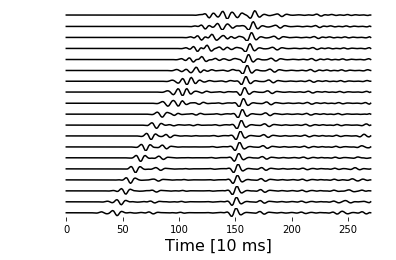

In [5]:
example = train_dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

## Defining the model, training and validation loop

We're now ready to train our network.  
We'll be using a simple single-hidden-layer neural network as is implemented in [Roeth and Tarantola 1994](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB01563)  
We train the network using a ```nn.MSELoss()``` for 200 epochs and anneal the learning rate on plateau's using ```torch.optim.lr_scheduler```.  
On colab this model trains extremely fast, so give it a try!  
I've added extensive comments to make sure all the steps are clearly documented.  
If anything is unclear, or broken, please submit an [issue](https://github.com/LukasMosser/SNIST/issues) or even better a [pull request](https://github.com/LukasMosser/SNIST/pulls).  

In [6]:
#Set the random number generator
set_seed(42)

#Weight Initialisation
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.00)

#Setup our model - simple neural network based on Roeth and Tarantola 1994
model = nn.Sequential(*[nn.Linear(N_samples*N_recorders, 25), nn.Sigmoid(), nn.Linear(25, N_layers), nn.Sigmoid()]).to(device)
model.apply(init_weights)
print("Total number of model parameters: ", count_parameters(model))

#Setup the SGD optimizer and learning rate stepper - momentum = 0 because they didn't use it at the time
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
stepper = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, min_lr=1e-5)

#Criterion will be the Mean-Squared-Error
criterion = nn.MSELoss(reduction="sum")

#Dummy variables to store intermediate results
losses = []
lowest_loss = np.inf
for epoch in range(N_epochs):
    model.train()
    train_loss = 0.0
    for X, y in train_loader: #Iterate over the training data
        optimizer.zero_grad() #Set our gradients to zero
        
        #Perform Normalisation
        X -= train_mean
        X /= train_std
        X = X.view(-1, X.size(2)*X.size(3))
        
        #Forward propagate the input data
        y_ = model(X.to(device))
        
        #Compute the loss
        loss = criterion(y_.to(device), y.to(device))
        
        #Backpropagate the loss
        loss.backward()
        
        #Make a small step to optimize
        optimizer.step()
        train_loss += loss.item() #Accumulate total training loss
        
    #Set model to evaluation mode
    model.eval()
    validation_loss = 0.0
    with torch.set_grad_enabled(False): #No need for gradients here
        for X, y in validation_loader: #Iterate over the validation set
            #Perform Normalisation
            X -= train_mean
            X /= train_std
            X = X.view(-1, X.size(2)*X.size(3))

             #Forward propagate the input data
            y_ = model(X.to(device))
            
            #Compute the loss
            loss = criterion(y_.to(device), y.to(device))
            validation_loss += loss.item()#Accumulate total validation loss
                
                
    #Compute the average losses per example in m/s (velocities)
    train_loss *= velo_max/len(train_loader.dataset)
    validation_loss *= velo_max/len(validation_loader.dataset)
    
    #Reduce learning rate if necessary
    stepper.step(validation_loss)
    
    #Get current learning rate - for output only
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    
    #Store best model if validation loss improved
    if lowest_loss > validation_loss:
        store_model_checkpoint("./best_model.pth", epoch, model, optimizer, validation_loss)
        lowest_loss = validation_loss

    #Append losses - for output only
    losses.append([train_loss, validation_loss])
    
    #Print output every 10 epochs
    if epoch % 10 == 9:
        print("Current Epoch: ", epoch, "Training Loss: %.3f" % train_loss, "[m/s], Validation Loss: %.3f" % validation_loss, "[m/s], Learning rate: %.6f"%lr)

Total number of model parameters:  135759
Current Epoch:  9 Training Loss: 366.004 [m/s], Validation Loss: 528.950 [m/s], Learning rate: 0.010000
Current Epoch:  19 Training Loss: 136.990 [m/s], Validation Loss: 363.552 [m/s], Learning rate: 0.010000
Current Epoch:  29 Training Loss: 95.623 [m/s], Validation Loss: 322.597 [m/s], Learning rate: 0.010000
Current Epoch:  39 Training Loss: 104.073 [m/s], Validation Loss: 335.019 [m/s], Learning rate: 0.010000
Current Epoch:  49 Training Loss: 67.282 [m/s], Validation Loss: 294.573 [m/s], Learning rate: 0.010000
Current Epoch:  59 Training Loss: 62.381 [m/s], Validation Loss: 274.480 [m/s], Learning rate: 0.010000
Current Epoch:  69 Training Loss: 54.422 [m/s], Validation Loss: 271.865 [m/s], Learning rate: 0.010000
Current Epoch:  79 Training Loss: 73.503 [m/s], Validation Loss: 312.777 [m/s], Learning rate: 0.010000
Current Epoch:  89 Training Loss: 74.793 [m/s], Validation Loss: 261.590 [m/s], Learning rate: 0.005000
Current Epoch:  99 T

## Plotting the training and validation loss 
Looking at our training and validation losses we can see that our network converges nicely.  
A few observations here:
- Both training and validation losses are decreasing i.e. our model is learning to invert the velocities given the seismic waveforms. 
- The training loss is much lower than the test loss, but not zero i.e. we haven't memorized the training set.
- Learning dynamics of the training and validation set are very similar:
  - Training error goes down, validation error goes down.
  - Training error goes up, validation error goes up.
- Reducing the learning rate did give a final push on the validation error of our model.
- The final learning rate is too small to induce any additional error reduction.

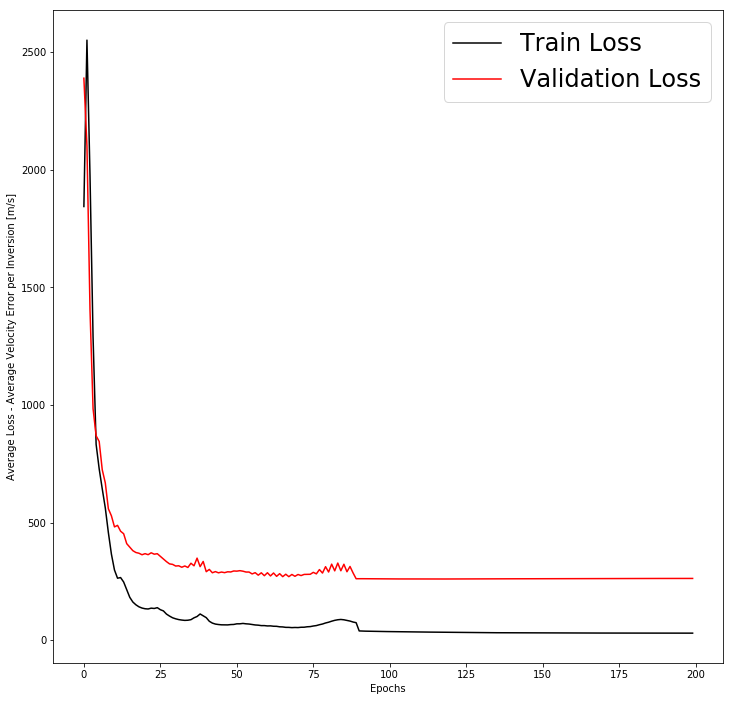

In [7]:
losses_np = np.array(losses)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_losses(ax, losses_np)
plt.legend(fontsize=24)

This leaves lots of room for improvement! :)  
Some initial tests with more fancy networks have shown great promise to outperform this simple approach - how good can we get?  

## Load the best model checkpoint
We'll take the model with the best epoch forward for testing on the three test sets.

In [8]:
model, _, epoch, loss = load_model_checkpoint("./best_model.pth", model, optimizer)
print("Best model is from epoch: ", epoch, " and had a loss of %.4f" % loss)

Best model is from epoch:  114  and had a loss of 260.4358


## Defining a helper function for model evaluation

In [0]:
def test(test_loader, model, mean, std, vmax, device='cpu'):
    model.eval()
    criterion = nn.MSELoss(reduction='sum')
    with torch.set_grad_enabled(False):
        for X, y in test_loader:
            X -= mean
            X /= std
            X = X.view(-1, X.size(2)*X.size(3))
            y_ = model(X.to(device))
            loss = criterion(y_.to(device), y.to(device))
    
    reported_loss = loss*vmax/len(test_loader.dataset)
    print("The average loss on the test set is %3.3f" %reported_loss.item(), " [m/s]")
    return X.to('cpu'), y.to('cpu'), y_.to('cpu'), reported_loss

## Evaluating the model on test set (no noise)

We'll now evaluate our model on the various test sets.  
First the test set with no noise added - only nice clean waveforms.

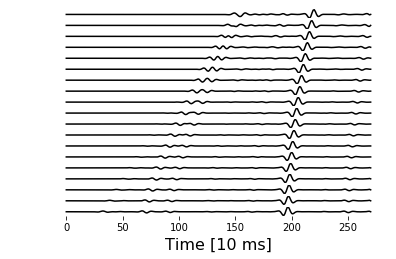

In [10]:
example = test_loader_noise_0.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

### Plotting the waveforms and inverted velocity profiles

We provide some helper functions to look at grids of the waveforms as well as their ground truth velocity profiles (black) and predicted velocities (red).

The average loss on the test set is 242.422  [m/s]


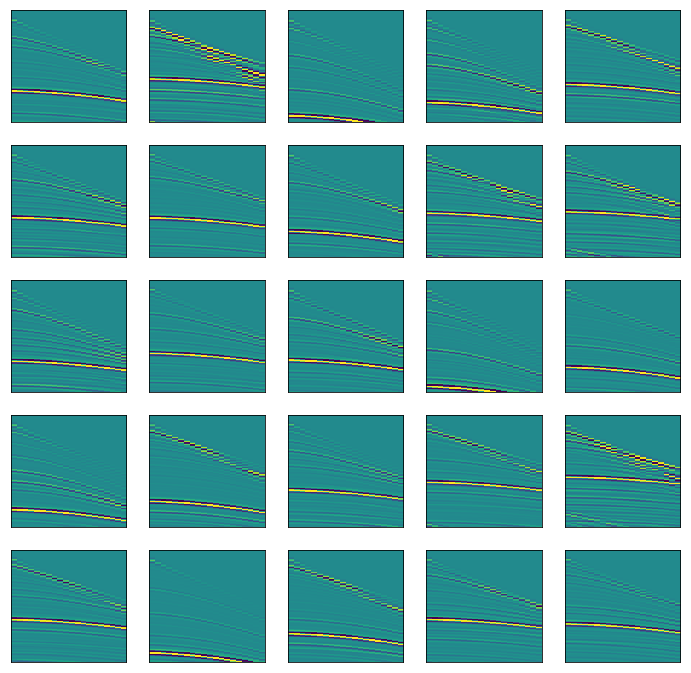

In [11]:
X, y, y_, test_loss_noise_0 = test(test_loader_noise_0, model, train_mean, train_std, velo_max, device=device)
ax, fig = plot_amplitudes_grid(X, N_samples, N_recorders)

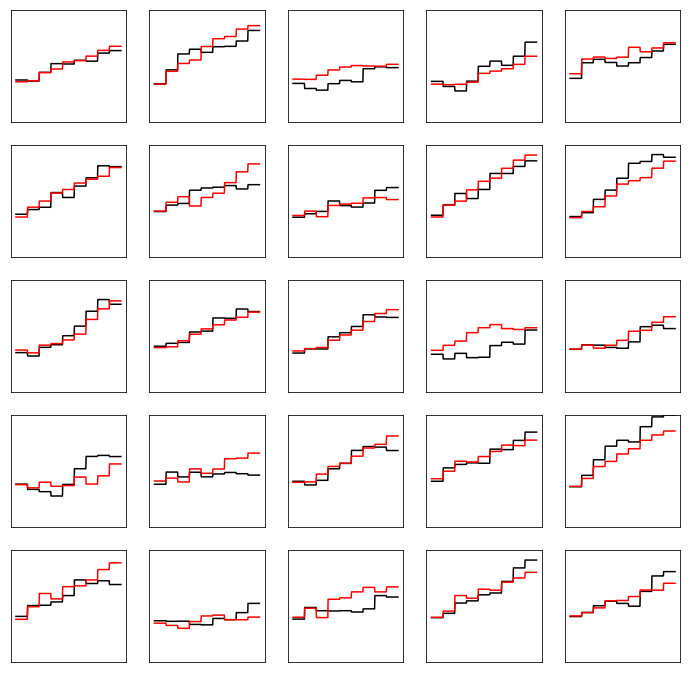

In [12]:
ax, fig = plot_velocity_profiles_grid(y, y_, N_z)

We can see that the network picks up the general trend of the velocity profiles even when there's not much increase in the velocities.

## Evaluating the model on test set ($1 \ \sigma$ noise)

Now for the second test set with $1 \sigma$ of noise - are we still performing well?

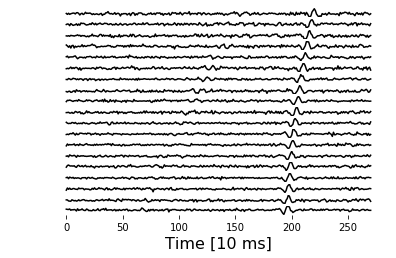

In [13]:
example = test_loader_noise_1.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

The average loss on the test set is 287.984  [m/s]


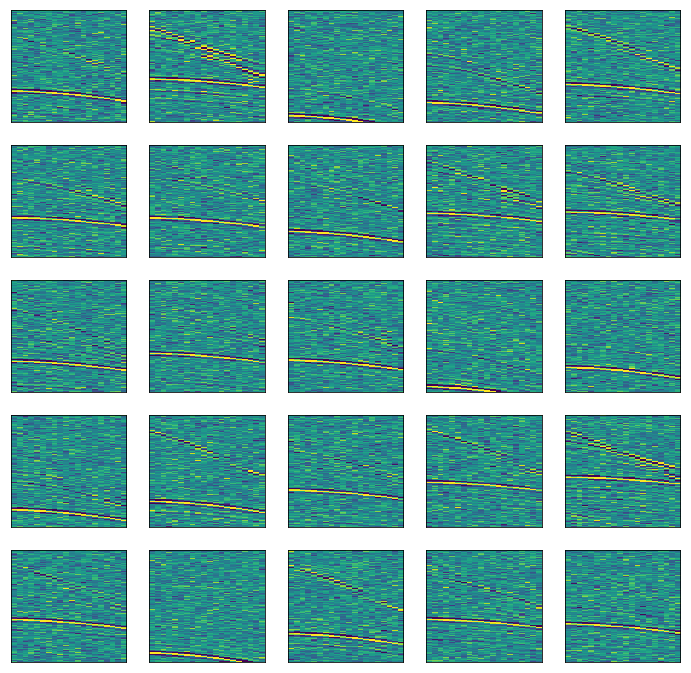

In [14]:
X, y, y_, test_loss_noise_1 = test(test_loader_noise_1, model, train_mean, train_std, velo_max, device=device)
ax, fig = plot_amplitudes_grid(X, N_samples, N_recorders)

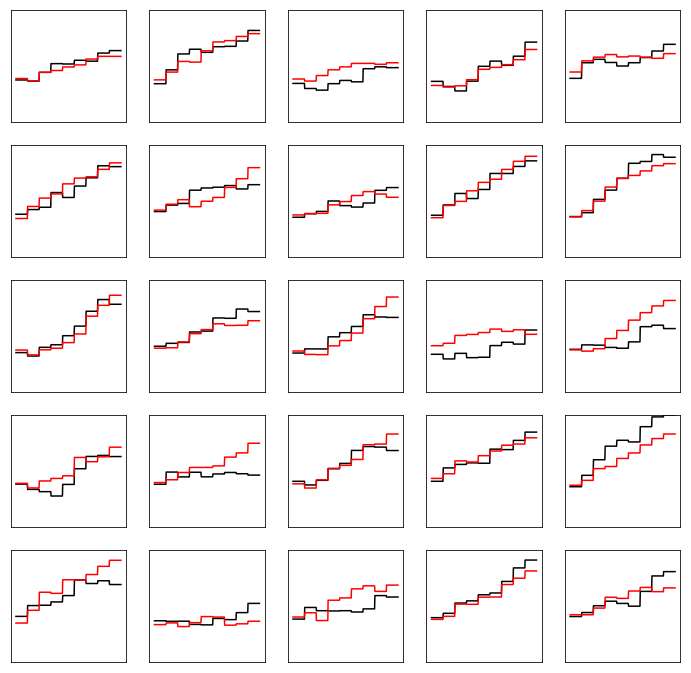

In [15]:
ax, fig = plot_velocity_profiles_grid(y, y_, N_z)

It seems even with considerable noise the network is still getting a large portion of the profile correct!
This is further indicated by a slightly higher test-set loss.

## Evaluating the model on test set ($2 \ \sigma$ noise)

Now for a real challenge - $2 \sigma$ of noise - surely the network has to break down at some point?

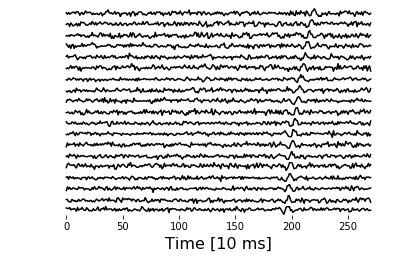

In [16]:
example = test_loader_noise_2.dataset[0][0].view(N_samples, N_recorders).numpy()
fig = plt.figure()
plot_wiggle_traces(fig, example, N_recorders)

The average loss on the test set is 428.595  [m/s]


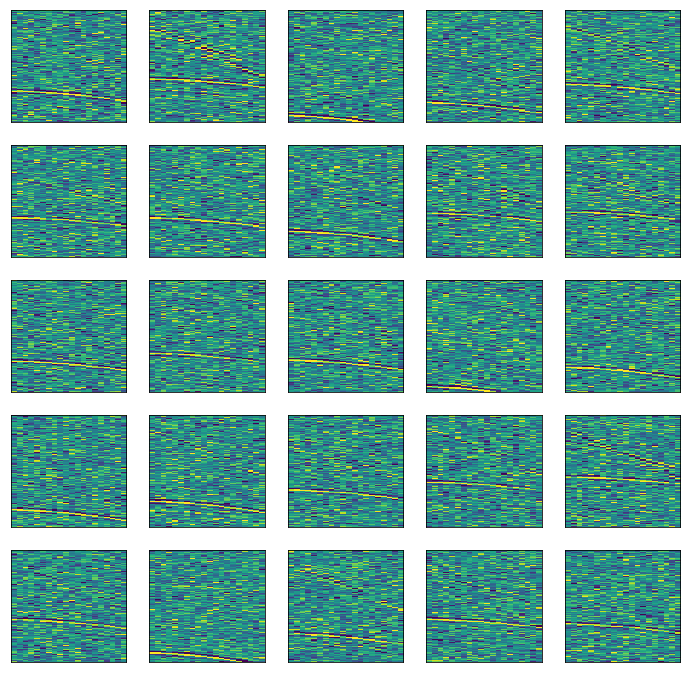

In [17]:
X, y, y_, test_loss_noise_2 = test(test_loader_noise_2, model, train_mean, train_std, velo_max, device=device)
ax = plot_amplitudes_grid(X, N_samples, N_recorders)

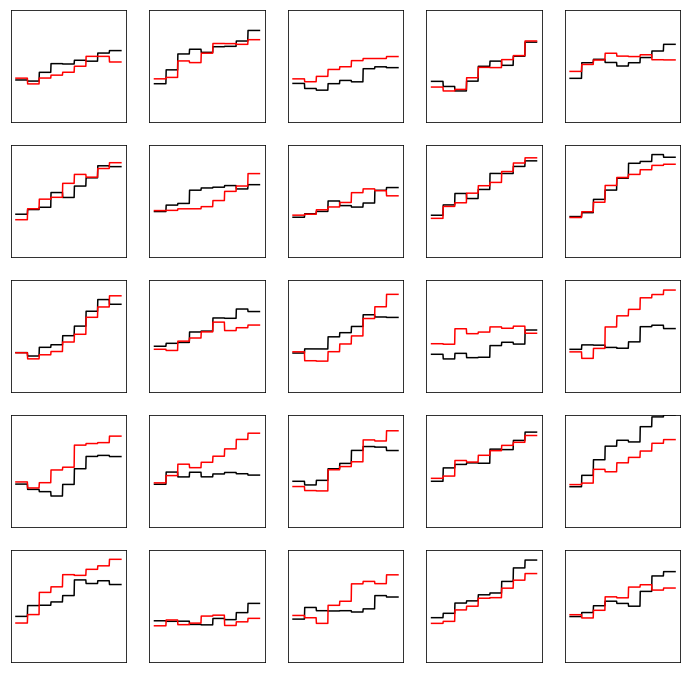

In [18]:
ax = plot_velocity_profiles_grid(y, y_, N_z)

We're starting to really push the limits of the network here.  
Some of the profiles are well captured others are way off.  
Surely we can improve on this in the future.  

In [19]:
print("Summary of the model performance on the test set: ")
print("Test Set 0 Loss: %3.3f" %test_loss_noise_0.item(), " [m/s]")
print("Test Set 1 Loss: %3.3f" % test_loss_noise_1.item(), " [m/s]")
print("Test Set 2 Loss: %3.3f" % test_loss_noise_2.item(), " [m/s]")

Summary of the model performance on the test set: 
Test Set 0 Loss: 242.422  [m/s]
Test Set 1 Loss: 287.984  [m/s]
Test Set 2 Loss: 428.595  [m/s]


The final summary of the three test sets shows this clearly:
- Test set 0 and Test set 1 almost have the same performance - adding noise only slightly made our predictions worse even though we trained on clean waveforms.  
- Adding $2 \sigma$ of noise really pushes the boundaries of this specific network type.

That is all for now - looking forward to see how we can improve on this task in the future!

Any questions hit me up on [twitter](https://twitter.com/porestar), raise an [issue](https://github.com/LukasMosser/SNIST/issues) or [pull request](https://github.com/LukasMosser/SNIST/pulls).
If you wish to have your implementation added to the benchmark leaderboard, please provide a reproducible version similar to this notebook so we can verify your approach and everyone can learn from your awesomness - thanks!